In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pyUSID as usid
import h5py
import pandas as pd
import xarray as xr

%matplotlib inline

In [2]:
data_dir = '../data'

## Analyze image data in h5 files to collect histograms

* The atoms have been found and separated into sub lattices using Stephen's method.


### Extract Mo and Re positions for each image

In [3]:
# select relevant atomic coordinates for further analysis
# different files store different atoms in centroids_1 and centroids_2 -> sort this out
names = ['re05', 're55', 're78', 're95'] # hdf5 file name roots

metal_atoms = []
intensities = []

for name in names:
    h5_name = os.path.join(data_dir, name +'.h5')
    
    h5_file = h5py.File(h5_name, 'r+')
    
    atom_pos_grp= h5_file['Measurement_000']['Channel_000']['Atom_Positions']
    atom_centroids_1 = atom_pos_grp['Atom_Centroids_1']
    atom_centroids_2 = atom_pos_grp['Atom_Centroids_2']
    cropped_image = atom_pos_grp['Cropped_Image'][:]
    
    # metal atoms stored only in atom_centroids_1?
    if name in ['re05', 're55']:
        atoms = atom_centroids_1
    else:
        atoms = np.vstack((atom_centroids_1, atom_centroids_2))
        
    metal_atoms.append(atoms)
    intensities.append(cropped_image)

In [4]:
# Separate atoms to Mo and Re based on image-specific intensity threshold
thresh = [0.80, 0.45, 0.45, 0.45] # intensity thresholds

# store types of atoms
atom_pos = []
atom_ids = []

for atoms, intensity, thrs in zip(metal_atoms, intensities, thresh):

    Re_atoms = []
    Mo_atoms = []

    for i in range(atoms.shape[0]):
        x, y = atoms[i,:]

        if intensity[int(x), int(y)] >= thrs:
            Re_atoms.append((x, y))
        else:
            Mo_atoms.append((x,y))
    
    Mo_atoms = np.array(Mo_atoms)
    Re_atoms = np.array(Re_atoms)

    all_atoms = np.vstack((Mo_atoms[:], Re_atoms[:])) #ignoring the sulfur atoms for now.
    
    all_atoms_ids = np.zeros(all_atoms.shape[0], dtype=int)
    all_atoms_ids[:Mo_atoms.shape[0]] = 0 #0 = Mo
    all_atoms_ids[Mo_atoms.shape[0]:] = 1 #1 = Re
    
    atom_pos.append(all_atoms)
    atom_ids.append(all_atoms_ids)

**Plot all images with indicated Mo and Re atoms**

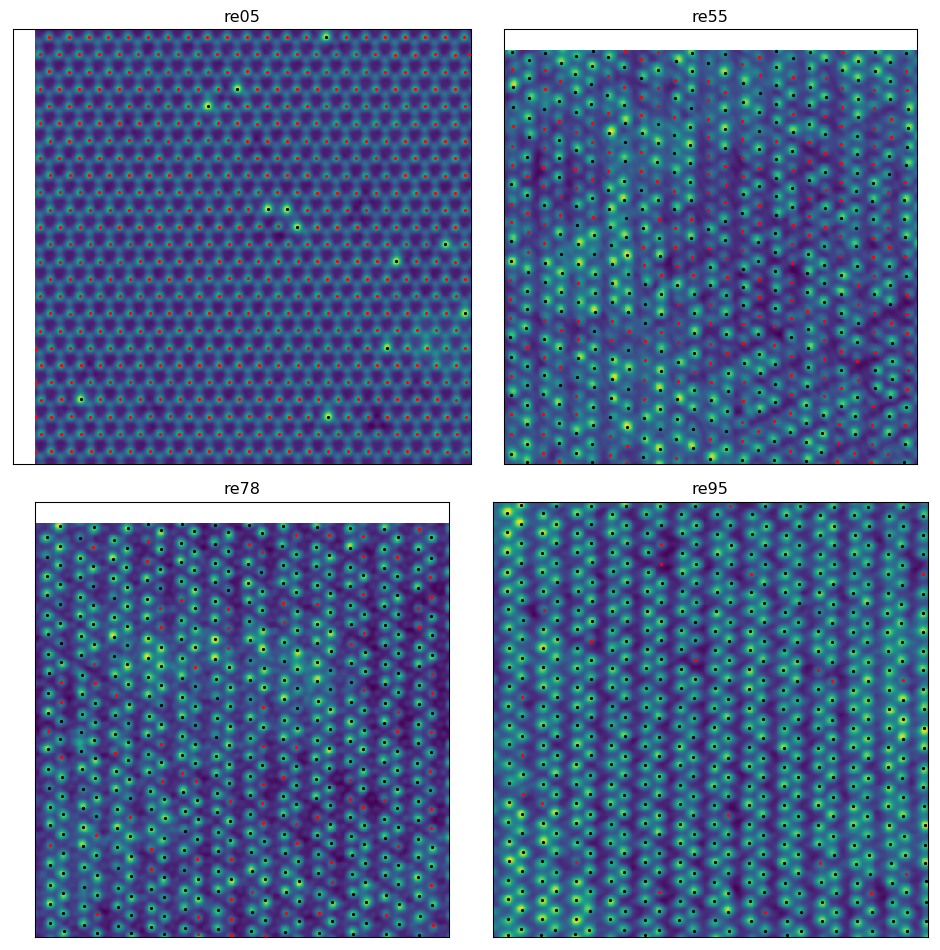

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), dpi = 96)

for i, (name, img, apos, aids) in enumerate(zip(names, intensities, atom_pos, atom_ids)):
    ir, ic = divmod(i, 2)
    axs[ir, ic].imshow(img)#, cmap = 'hot')
    axs[ir, ic].scatter(apos[aids==0,1], apos[aids==0,0], c = 'r', s = 2)
    axs[ir, ic].scatter(apos[aids==1,1], apos[aids==1,0], c = 'k', s = 2)
    axs[ir, ic].get_xaxis().set_visible(False)
    axs[ir, ic].get_yaxis().set_visible(False)
    axs[ir, ic].set_title(name)

plt.tight_layout()
plt.show()

**Function to calculate atom-atom distances**

In [6]:
def dist_calc(pt, pts):
    """Distance between a point 'pt' and a list of points 'pts'"""
    
    distances = []
    for ind in range(pts.shape[0]):
        distances.append((np.sqrt((pt[0] - pts[ind,0])**2 + (pt[1] - pts[ind,1])**2), ind))
    
    return distances

**Make hexagon neighbor configuration more regular for further analysis of pair relations**

In [7]:
def hexagon(pos):
    """
    Scale neighbor positions so that they have the same distance from their center of mass.
    """
    
    com_x = sum([p[0] for p in pos])/len(pos)
    com_y = sum([p[1] for p in pos])/len(pos)
    
    pos_hex = []
    for p in pos:
        dx = p[0] - com_x
        dy = p[1] - com_y
        r = (dx*dx + dy*dy)**0.5
        pos_hex.append([dx/r, dy/r])
    
    return pos_hex

**Configuration classification function**

In [8]:
def classify(pos, ids):
    """
    Assign unique identifiers to the neighbor configurations
    """
    
    # scale to make the neighbor hexagon more regular
    pos = hexagon(pos)
    
    # collect pair distances between neighbors and add the pair type (0, 1, 2)
    pair_list = []
    for i in range(len(pos)):
        for j in range(i+1, len(pos)):
            r = np.sqrt((pos[i][0]-pos[j][0])**2 + (pos[i][1]-pos[j][1])**2)
            pair_list.append((r, ids[i]+ids[j]))
    
    assert len(pair_list) == 15, f'Wrong number of pair distances: {len(pair_list)}'
    
    # number of Re atoms in the neighbor list
    n_atom = sum([1 for elem in ids if elem == 1])
    
    # sort the pair list according to distances
    pair_list = sorted(pair_list, key=lambda x: x[0])
    
    # number of Re-Re pairs among the 6 shortest distances distances (ortho)
    n_ortho = sum([1 for elem in pair_list[0:6] if elem[1] == 2])
    
    # number of Re-Re pairs among the 6 medium distances distances (meta)
    n_meta = sum([1 for elem in pair_list[6:12] if elem[1] == 2])
    
    # number of Re-Re pairs among the 3 longest distances distances (para)
    n_para = sum([1 for elem in pair_list[12:15] if elem[1] == 2])

    return [n_atom, n_ortho, n_meta, n_para]

**Collect histograms of all possible configurations**

In [9]:
from collections import Counter

# Image specific distance thresholds
dist_thres = [45, 32, 30, 26]

target_hist = {}

# cycle over lists of atoms from different images
for name, apos, aids, dthres in zip(names, atom_pos, atom_ids, dist_thres):

    configs = []
    
    # for each atom, find its neighbors, center it
    for i, (c_pos, c_id) in enumerate(zip(apos, aids)):
        
        x, y = c_pos
        distances = dist_calc([x, y], apos)

        neighbor_i = []
        neighbor_pos = []
        neighbor_id = []
        for k in range(len(distances)):
            if distances[k][0] <= dthres and distances[k][0] > 0:
                j = distances[k][1]
                neighbor_i.append(j)
                neighbor_pos.append(apos[j])
                neighbor_id.append(aids[j])
        
        if len(neighbor_i) < 6:
            continue
            
        assert len(neighbor_i) == 6, f"Incorrect number of neighbors: {len(neighbor_i)}, {name}"
        
        # classify configurations - assign unique ids based on counts of ortho, meta, and para distances
        configs.append(tuple([c_id] + classify(neighbor_pos, neighbor_id)))
            
    # get counts of distinct configuraions
    counts = Counter(configs)
    print('Number of configuration types:', len(counts))
    print('Total number of configurations (atoms with 6 neighbors):', sum(counts.values()))#, counts)
    target_hist[name] = counts

Number of configuration types: 8
Total number of configurations (atoms with 6 neighbors): 464
Number of configuration types: 25
Total number of configurations (atoms with 6 neighbors): 466
Number of configuration types: 13
Total number of configurations (atoms with 6 neighbors): 434
Number of configuration types: 6
Total number of configurations (atoms with 6 neighbors): 471


**Create a set of all dictinct configurations found in the four images**

In [10]:
cfg_list = [c for h in target_hist.values() for c in h]
cfg_types = sorted(set(cfg_list))
print('Number of distinct configurations:', len(cfg_types))

Number of distinct configurations: 26


In [11]:
x_re = {}
for name in names:
    re_sum = sum([v for k, v in target_hist[name].items() if k[0]==1])
    mo_sum = sum([v for k, v in target_hist[name].items() if k[0]==0])
    c = re_sum/(re_sum + mo_sum)
    x_re[name] = c

print(x_re.values())

dict_values([0.021551724137931036, 0.5965665236051502, 0.8433179723502304, 0.9575371549893843])


**Plot configuration histograms for different images**

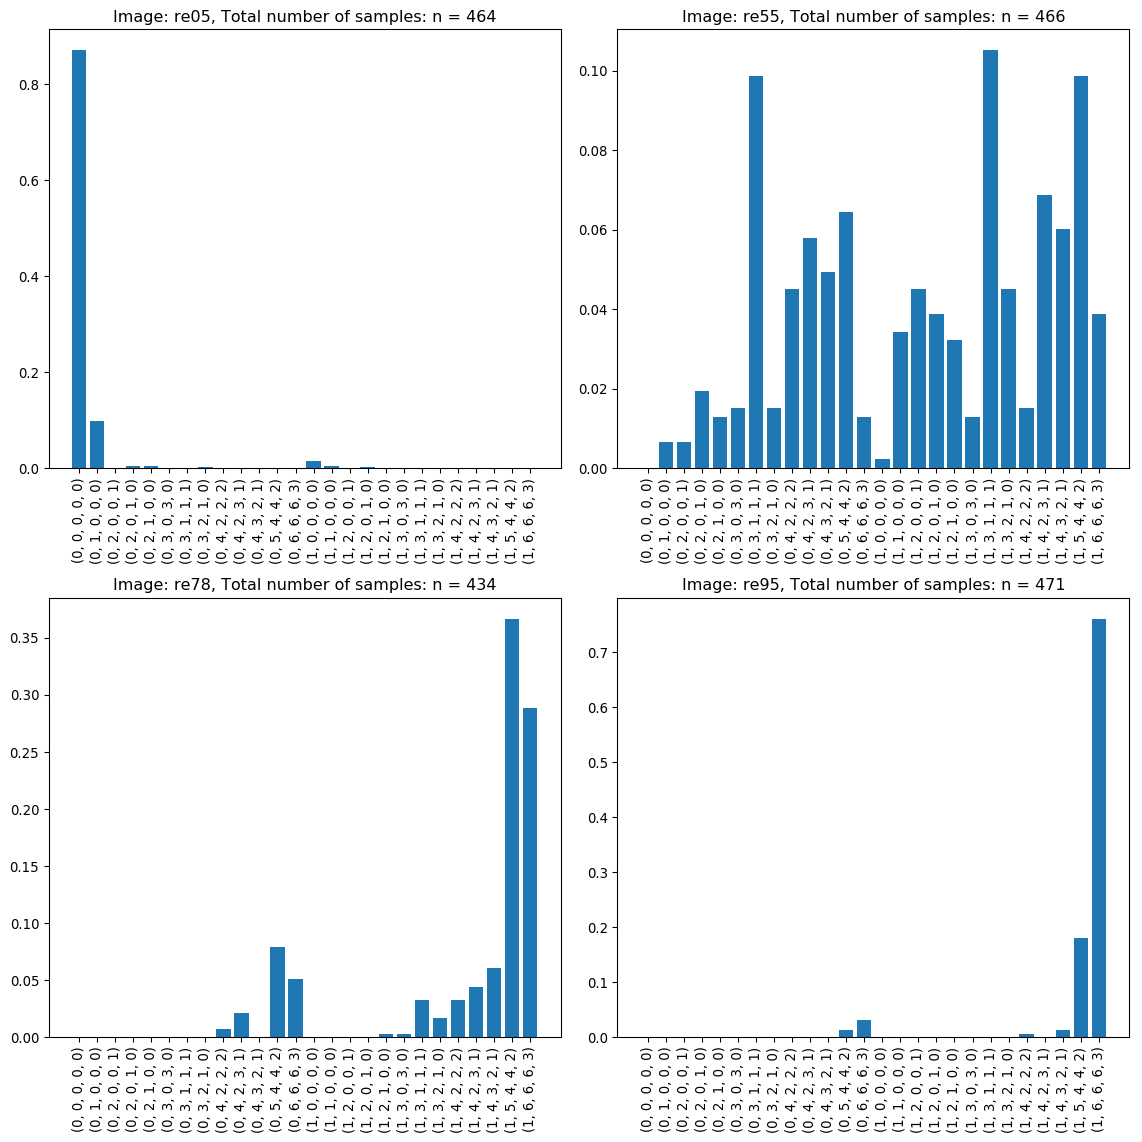

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), dpi = 96)

cfg_labels = [str(c) for c in cfg_types]
num_samples = {}
for i, name in enumerate(names):
    counts = target_hist[name]
    all_counts = np.array([counts.get(cfg, 0) for cfg in cfg_types])
    n_sample = np.sum(all_counts)
    num_samples[name] = n_sample
    all_counts = all_counts/float(n_sample)

    ir, ic = divmod(i, 2)
    axs[ir, ic].bar(cfg_labels, all_counts)
    axs[ir, ic].set_xticklabels(cfg_labels, rotation=90.0)
    axs[ir, ic].set_title('Image: ' + name + ', Total number of samples: n = ' + str(n_sample))
    
plt.tight_layout()
plt.show()

## Assign configuration ID from simulations to ID from image analysis

In [13]:
from itertools import product
from collections import Counter

# Neighbor hexagon positions
neighbor_pos = [
    [1.0, 0.0],
    [-1.0, 0.0],
    [ np.cos(np.pi/3.0),  np.sin(np.pi/3.0)],
    [-np.cos(np.pi/3.0),  np.sin(np.pi/3.0)],
    [ np.cos(np.pi/3.0), -np.sin(np.pi/3.0)],
    [-np.cos(np.pi/3.0), -np.sin(np.pi/3.0)],
]

conf_dict = {}

i = 0
for c_id in range(2): # pick center atom type                                           
    dx = c_id                                                                           
    for neighbor_id in product((0, 1), repeat=6):

        conf_id = tuple([c_id] + classify(neighbor_pos, neighbor_id))
            
        i += 1                                                      
        conf_dict[i] = conf_id

conf_counts = Counter(conf_dict.values())

In [14]:
# random configuration probabilities

ntot = 7 # number of atoms in the configuration

prob_conf = {}
for name in names:
    x = x_re[name]
    p_c = {}
    for k, v in conf_counts.items():
        
        # number of Re atoms in the configuration
        n_re = k[0] + k[1]
        
        #probability of a configuration with n_re atoms
        prob = x**n_re * (1.0-x)**(ntot - n_re)
        
        # weight probability by symmetry numbers (v)
        p_c[k] = prob*v
            
    prob_conf[name] = p_c

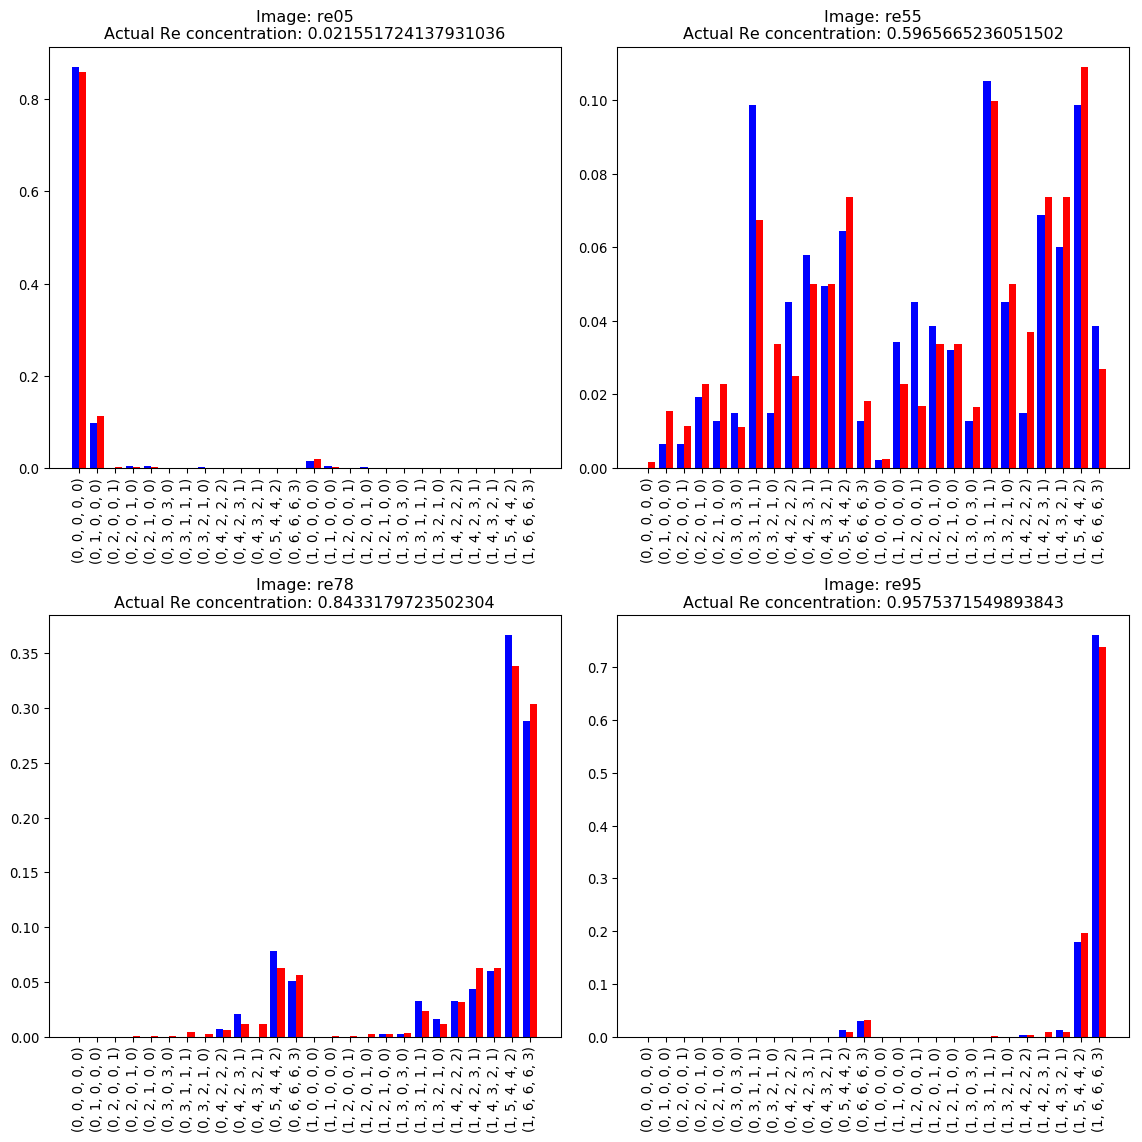

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), dpi = 96)

cfg_labels = [str(c) for c in cfg_types]
for i, name in enumerate(names):
    counts = target_hist[name]
    p_conf = prob_conf[name]
    all_counts = np.array([counts.get(cfg, 0) for cfg in cfg_types])
    n_sample = np.sum(all_counts)
    all_counts = all_counts/float(n_sample)

    p_array = [(k, v) for k, v in p_conf.items()]
    #cft_labels = [str(k[0]) for k in p_array]
    #all_counts_p = [float(k[1]) for k in p_array]
    all_counts_p = np.array([prob_conf[name].get(cfg, 0) for cfg in cfg_types])

    
    nconf = len(cfg_labels)
    width = 0.4

    ir, ic = divmod(i, 2)
    axs[ir, ic].bar(np.arange(nconf)-0.2, all_counts, width, color='b')
    axs[ir, ic].bar(np.arange(nconf)+0.2, all_counts_p, width, color='r')
    axs[ir, ic].set_xticks(range(nconf))
    axs[ir, ic].set_xticklabels(cfg_labels, rotation=90.0)
    axs[ir, ic].set_title('Image: ' + name + '\nActual Re concentration: ' + str(x_re[name]))#', Total number of samples: n = ' + str(n_sample))
    
plt.tight_layout()
plt.show()

In [16]:
%load_ext autoreload
%autoreload 2

In [17]:
sys.path.append('../../../force_fields/statmechlib')
from statmechlib.read_write import read_lattice_model, read_modeldef, write_modeldef
from statmechlib.preprocessing import get_stats_latt 
from statmechlib.forcefields import sd2

In [18]:
sim_dir = '../src/code'

In [19]:
# read reference system parameters into an array
pars_ref = {}
for name in names:
    data_path = os.path.join(sim_dir, name)
    params = read_modeldef(os.path.join(data_path, 'lg.mld'))
    pars_ref[name] = np.array([v for v in params['ref_params'].values()]).flatten(order='F')

assert len(set([str(v) for v in pars_ref.values()])) == 1, "Different parameters"

pars_ref = pars_ref[names[0]]
pars_ref

array([ 0.        ,  0.10573289,  0.        ,  0.        , -0.45494785,
        0.        ])

In [20]:
# read lattice simulation results: configuration statistics and energies
trjs = {}
for name in names:
    data_path = os.path.join(sim_dir, name)
    trjs[name] = read_lattice_model(data_path)

Reading ../src/code/re05/lg.hst
Reading ../src/code/re05/lg.run
Reading ../src/code/re55/lg.hst
Reading ../src/code/re55/lg.run
Reading ../src/code/re78/lg.hst
Reading ../src/code/re78/lg.run
Reading ../src/code/re95/lg.hst
Reading ../src/code/re95/lg.run


In [21]:
# Make transformation matrix from old to new histogram
trans_hist = {}
conf_list = sorted(list(set(conf_dict.values()))) # row index
nrows = len(conf_list) 
ncols = len(conf_dict)
print(nrows, ncols)

trans_hist = np.zeros((nrows, ncols), dtype=float)
for key, val in conf_dict.items():
    # find index for the first occurence of the value
    #row = [i for i, e in enumerate(conf_list) if e == val][0]
    row = conf_list.index(val)
    col = key - 1
    trans_hist[row, col] = 1.0

26 128


In [22]:
# group symmetric configurations based on their unique label
hsv = {}
hsv_ave = {}
for name in names:
    old_hist = np.array(trjs[name]['config_stats'])
    hsv[name] = trans_hist.dot(old_hist.T).T
    for i in range(hsv[name].shape[0]):
        sm = np.sum(hsv[name][i,:])
        hsv[name][i,:] = hsv[name][i,:]/sm
    
    histave = []
    for i in range(hsv[name].shape[1]):
        histave.append(sum(hsv[name][:,i])/float(hsv[name].shape[0]))
    hsv_ave[name] = np.array(histave)

In [23]:
# filter the results (discard initial configurations)
hsu = {}
for name in names:
    hsu[name] = np.array([np.array(ar).flatten(order='F') for ar in trjs[name]['interaction_stats']])

In [24]:
# filter the results (discard initial configurations)
imin = 10
for name in names:
    hsv[name] = hsv[name][imin:,:]
    hsu[name] = hsu[name][imin:,:]
    trjs[name]['energy'] = trjs[name]['energy'][imin:]
    trjs[name]['temp'] = trjs[name]['temp'][imin:]

In [25]:
len(trjs['re05']['energy'])

9991

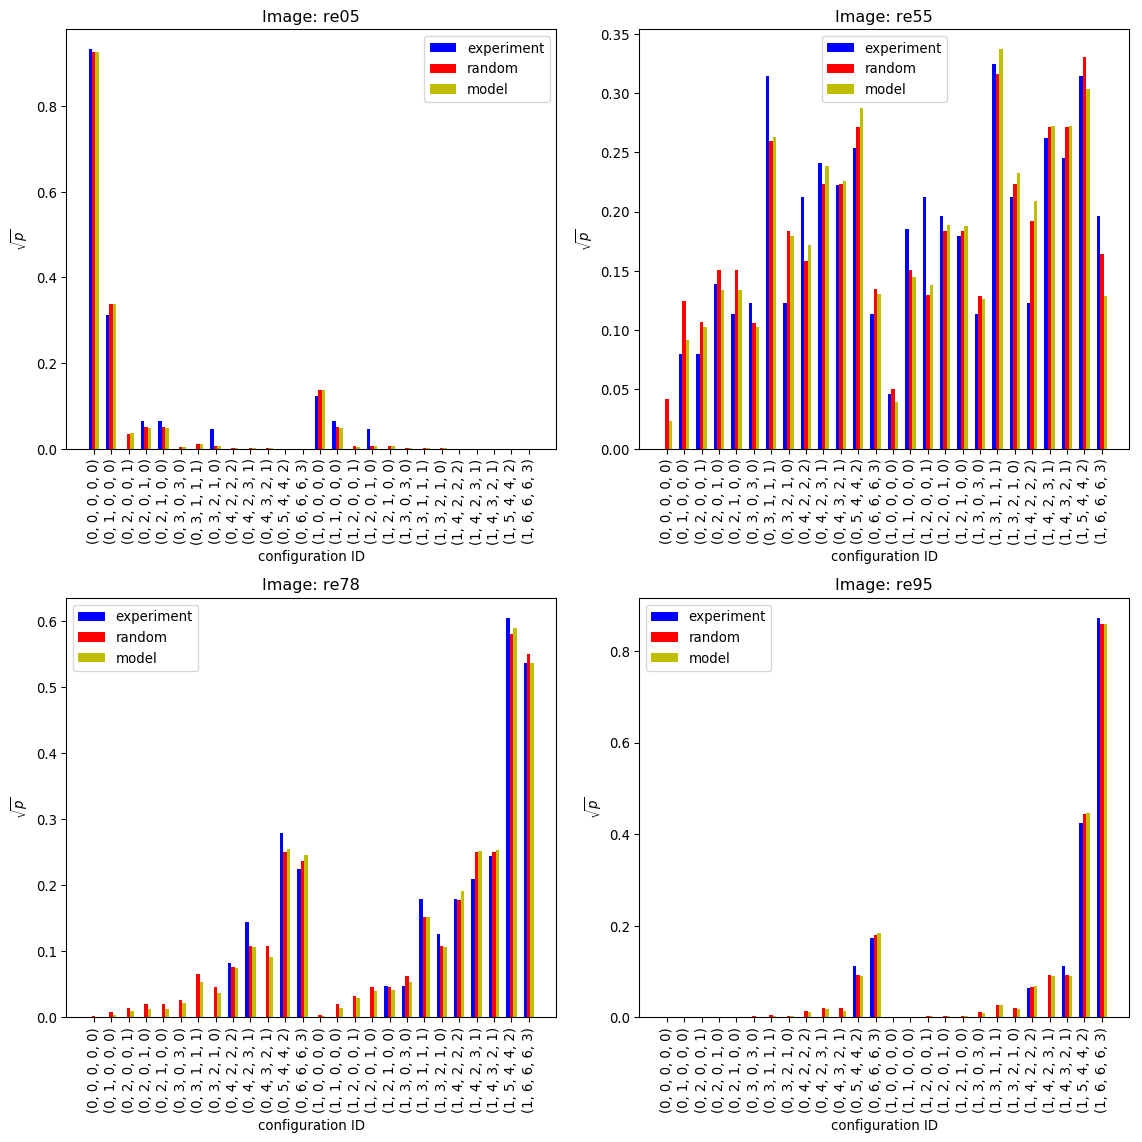

In [26]:
# compare simulated statistics with target and random histograms
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), dpi = 96)

cfg_labels = [str(c) for c in cfg_types]
gsv = {}
for i, name in enumerate(names):
    counts = target_hist[name]
    #p_conf = prob_conf[name]
    all_counts = np.array([counts.get(cfg, 0) for cfg in cfg_types])
    n_sample = np.sum(all_counts)
    all_counts = all_counts/float(n_sample)
    gsv[name] = all_counts
    all_counts_p = np.array([prob_conf[name].get(cfg, 0) for cfg in cfg_types])

    nconf = len(cfg_labels)
    width = 0.2

    ir, ic = divmod(i, 2)
    axs[ir, ic].bar(np.arange(nconf)-0.2, np.sqrt(all_counts), width, color='b', label='experiment')
    axs[ir, ic].bar(np.arange(nconf)+0.0, np.sqrt(all_counts_p), width, color='r', label='random')
    axs[ir, ic].bar(np.arange(nconf)+0.2, np.sqrt(hsv_ave[name]), width, color='y', label='model')
    axs[ir, ic].set_xticks(range(nconf))
    axs[ir, ic].set_xticklabels(cfg_labels, rotation=90.0)
    axs[ir, ic].set_title('Image: ' + name)# + ', Total number of samples: n = ' + str(n_sample))
    axs[ir, ic].set_xlabel('configuration ID')
    axs[ir, ic].set_ylabel(r'$\sqrt{p}$')
    axs[ir, ic].legend()

plt.tight_layout()
plt.show()

In [27]:
# Assemble target and reference data structures
targets = {}
stats = {}
for name in names:
    # target
    targ = {}
    targ['config_stats'] = gsv[name]
    targ['weight'] = num_samples[name]/sum(num_samples.values())
    targets[name] = targ
    
    # reference data
    stat = {}
    stat['config_stats'] = hsv[name]
    stat['interaction_stats'] = hsu[name]
    stat['energy'] = np.array(trjs[name]['energy'])
    stat['temp'] = np.array(trjs[name]['temp'])
    stats[name] = stat

In [28]:
pars_in = np.array([pars_ref[1], pars_ref[4]])

In [29]:
from scipy.optimize import fmin

print('# Start sd2 =', sd2(pars_in, stats, targets))
print('# Starting parameters:', pars_in)
output = fmin(sd2, pars_in, args=(stats, targets), maxiter=100000, maxfun=10000, disp=0, full_output=1)
print('\n# End sd2 =', output[1])
p_out = output[0]
print('# Final parameters:', p_out)

# Start sd2 = 0.018160806328013153
# Starting parameters: [ 0.10573289 -0.45494785]

# End sd2 = 0.01640894339541241
# Final parameters: [-1.57470546  1.66434636]


In [30]:
# set new parameters
pars = [0., p_out[0], 0., 0., p_out[1], 0.]

# write model definition file into a simulation directory
for name in names:
    data_path = os.path.join(sim_dir, name)
    print(os.path.join(data_path, 'lg.mld'))
    write_modeldef(os.path.join(data_path, 'lg.mld'), pars)

../src/code/re05/lg.mld
../src/code/re55/lg.mld
../src/code/re78/lg.mld
../src/code/re95/lg.mld


In [31]:
# Run simulations and wait until they are complete

#from subprocess import Popen, PIPE

#f_list = glob.glob('./*bz2')
#cmds_list = [['./bunzip2_file.py', file_name] for file_name in f_list]
#procs_list = [Popen(cmd, stdout=PIPE, stderr=PIPE) for cmd in cmds_list]

#original_dir = os.getcwd()

#os.chdir(sim_dir)

#proc_list = []
#for name in names:
    
#    os.chdir('./'+name)
#    cmd = './lg < ' + name + '.inp > lg.run'
#    proc_list.append(Popen(cmd, stdout=PIPE, stderr=PIPE))
#    os.chdir('..')

#for proc in procs_list:
#    proc.wait()

#os.chdir(original_dir)

0.07051797 -0.27910435

0.02054406 -0.50064873

0.06463121 -0.22251215 0.018662095932150156

0.02972088 -0.30352361 0.018200443606690948

0.10573289 -0.45494785 0.01816080620437813

Re05


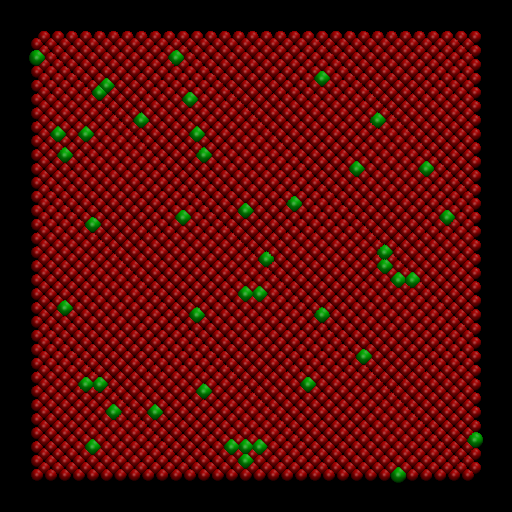

In [32]:
from IPython.display import Image
from IPython.core.display import HTML 

print('Re05')
Image("../reports/r05.png", width=300, height=300)

Re55


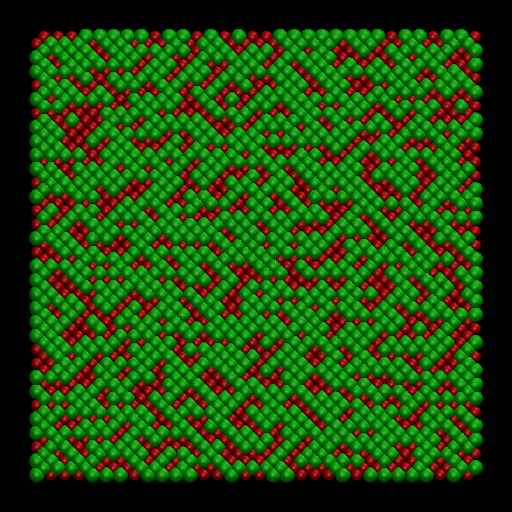

In [33]:
print('Re55')
Image("../reports/r55.png", width=300, height=300)

Re78


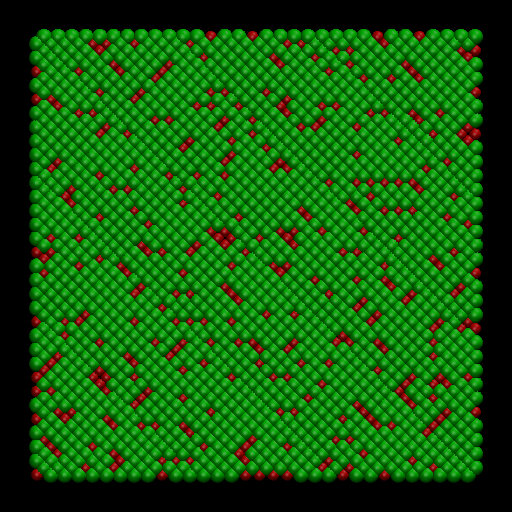

In [34]:
print('Re78')
Image("../reports/r78.png", width=300, height=300)

Re95


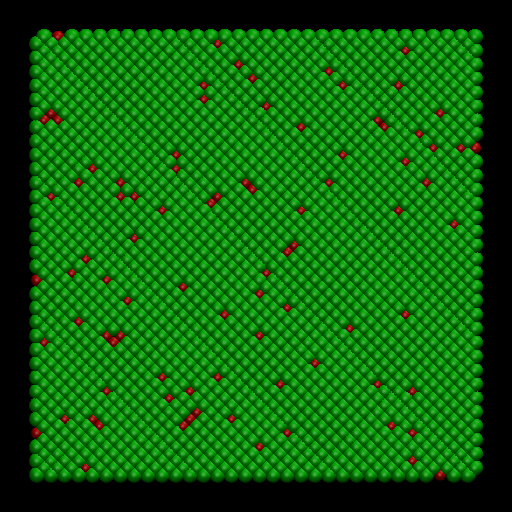

In [35]:
print('Re95')
Image("../reports/r95.png", width=300, height=300)